In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

In [84]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### Load Data

In [85]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [6]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'
filename_B1 = 'AC/AC_all.hdf5'
filename_B2 = 'CNNS/CNNS_all.hdf5'
filename_B3 = 'RN/RN_all.hdf5'
filename_B4 = 'WALL/WALL_all.hdf5'



###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [15]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_B1 = h5py.File(filefolder+filename_B1,'r')
f_B2 = h5py.File(filefolder+filename_B2,'r')
f_B3 = h5py.File(filefolder+filename_B3,'r')
f_B4 = h5py.File(filefolder+filename_B4,'r')

f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [32]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 5000


NUM_DAT_AC = round(num_data*f_AC)
NUM_DAT_CNNS = max(2, round(num_data*f_CNNS))
NUM_DAT_RN = round(num_data*f_RN)
NUM_DAT_WALL = round(num_data*f_WALL)

NUM_DAT_ER = num_data - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

In [33]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_B1 = 0
max_pS1_B2 = 0
max_pS1_B3 = 0
max_pS1_B4 = 0

max_pS1_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS1_B1 = max(max_pS1_B1, len( f_B1['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS1_B2 = max(max_pS1_B2, len( f_B2['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS1_B3 = max(max_pS1_B3, len( f_B3['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL+1):
    max_pS1_B4 = max(max_pS1_B4, len( f_B4['peakS1_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_B1,max_pS1_B2,max_pS1_B3,max_pS1_B4,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_B1 = np.pad(f_B1['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B1), 'constant')
peakS1_onlyhits_B2 = np.pad(f_B2['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B2), 'constant')
peakS1_onlyhits_B3 = np.pad(f_B3['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B3), 'constant')
peakS1_onlyhits_B4 = np.pad(f_B4['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B4), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B1 = np.pad(f_B1['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B1), 'constant')
    peakS1_onlyhits_B1 = np.row_stack([peakS1_onlyhits_B1,aux_S1_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B2 = np.pad(f_B2['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B2), 'constant')
    peakS1_onlyhits_B2 = np.row_stack([peakS1_onlyhits_B2,aux_S1_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B3 = np.pad(f_B3['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B3), 'constant')
    peakS1_onlyhits_B3 = np.row_stack([peakS1_onlyhits_B3,aux_S1_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B4 = np.pad(f_B4['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B4), 'constant')
    peakS1_onlyhits_B4 = np.row_stack([peakS1_onlyhits_B4,aux_S1_B4])
    
for i in range(2, num_data+1):
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B[:NUM_DAT_ER],peakS1_onlyhits_B1[:NUM_DAT_AC],peakS1_onlyhits_B2[:NUM_DAT_CNNS],peakS1_onlyhits_B3[:NUM_DAT_RN],peakS1_onlyhits_B4[:NUM_DAT_WALL],peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_B1
del peakS1_onlyhits_B2
del peakS1_onlyhits_B3
del peakS1_onlyhits_B4
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  178

X_mon1_train :  (4999, 178)
y_mon1_train :  (4999,)
X_mon1_val :  (1667, 178)
y_mon1_val :  (1667,)
X_mon1_test :  (3334, 178)
y_mon1_test :  (3334,)



In [35]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_B1 = 0
max_pS2_B2 = 0
max_pS2_B3 = 0
max_pS2_B4 = 0

max_pS2_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS2_B1 = max(max_pS2_B1, len( f_B1['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS2_B2 = max(max_pS2_B2, len( f_B2['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS2_B3 = max(max_pS2_B3, len( f_B3['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL
               
               
               +1):
    max_pS2_B4 = max(max_pS2_B4, len( f_B4['peakS2_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_B1,max_pS2_B2,max_pS2_B3,max_pS2_B4,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_B1 = np.pad(f_B1['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B1), 'constant')
peakS2_onlyhits_B2 = np.pad(f_B2['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B2), 'constant')
peakS2_onlyhits_B3 = np.pad(f_B3['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B3), 'constant')
peakS2_onlyhits_B4 = np.pad(f_B4['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B4), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B1 = np.pad(f_B1['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B1), 'constant')
    peakS2_onlyhits_B1 = np.row_stack([peakS2_onlyhits_B1,aux_S2_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B2 = np.pad(f_B2['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B2), 'constant')
    peakS2_onlyhits_B2 = np.row_stack([peakS2_onlyhits_B2,aux_S2_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B3 = np.pad(f_B3['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B3), 'constant')
    peakS2_onlyhits_B3 = np.row_stack([peakS2_onlyhits_B3,aux_S2_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B4 = np.pad(f_B4['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B4), 'constant')
    peakS2_onlyhits_B4 = np.row_stack([peakS2_onlyhits_B4,aux_S2_B4])
for i in range(2, num_data+1):
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B[:NUM_DAT_ER],peakS2_onlyhits_B1[:NUM_DAT_AC],peakS2_onlyhits_B2[:NUM_DAT_CNNS],peakS2_onlyhits_B3[:NUM_DAT_RN],peakS2_onlyhits_B4[:NUM_DAT_WALL],peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_B1
del peakS2_onlyhits_B2
del peakS2_onlyhits_B3
del peakS2_onlyhits_B4
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (4999, 2298)
y_mon2_train :  (4999,)
X_mon2_val :  (1667, 2298)
y_mon2_val :  (1667,)
X_mon2_test :  (3334, 2298)
y_mon2_test :  (3334,)



In [37]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_B1 = np.array( f_B1['HITS_bot/ev_1'] )
hits_bot_B2 = np.array( f_B2['HITS_bot/ev_1'] )
hits_bot_B3 = np.array( f_B3['HITS_bot/ev_1'] )
hits_bot_B4 = np.array( f_B4['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    hits_bot_B1 = np.row_stack([hits_bot_B1,np.array( f_B1['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    hits_bot_B2 = np.row_stack([hits_bot_B2,np.array( f_B2['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    hits_bot_B3 = np.row_stack([hits_bot_B3,np.array( f_B3['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    hits_bot_B4 = np.row_stack([hits_bot_B4,np.array( f_B4['HITS_bot/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B[:NUM_DAT_ER],hits_bot_B1[:NUM_DAT_AC],hits_bot_B2[:NUM_DAT_CNNS],hits_bot_B3[:NUM_DAT_RN],hits_bot_B4[:NUM_DAT_WALL],hits_bot_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_B1
del hits_bot_B2
del hits_bot_B3
del hits_bot_B4
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (4999, 121)
y_mon3_train :  (4999,)
X_mon3_val :  (1667, 121)
y_mon3_val :  (1667,)
X_mon3_test :  (3334, 121)
y_mon3_test :  (3334,)



In [38]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_B1 = np.array( f_B1['HITS_top/ev_1'] )
hits_top_B2 = np.array( f_B2['HITS_top/ev_1'] )
hits_top_B3 = np.array( f_B3['HITS_top/ev_1'] )
hits_top_B4 = np.array( f_B4['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    hits_top_B1 = np.row_stack([hits_top_B1,np.array( f_B1['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    hits_top_B2 = np.row_stack([hits_top_B2,np.array( f_B2['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    hits_top_B3 = np.row_stack([hits_top_B3,np.array( f_B3['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    hits_top_B4 = np.row_stack([hits_top_B4,np.array( f_B4['HITS_top/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B[:NUM_DAT_ER],hits_top_B1[:NUM_DAT_AC],hits_top_B2[:NUM_DAT_CNNS],hits_top_B3[:NUM_DAT_RN],hits_top_B4[:NUM_DAT_WALL],hits_top_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_B1
del hits_top_B2
del hits_top_B3
del hits_top_B4
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (4999, 127)
y_mon4_train :  (4999,)
X_mon4_val :  (1667, 127)
y_mon4_val :  (1667,)
X_mon4_test :  (3334, 127)
y_mon4_test :  (3334,)



In [39]:
# close the h5 files
f_B.close()
f_B1.close()
f_B2.close()
f_B3.close()
f_B4.close()
f_S.close()

##### Load the compressed features

In [40]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)



B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)

S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)


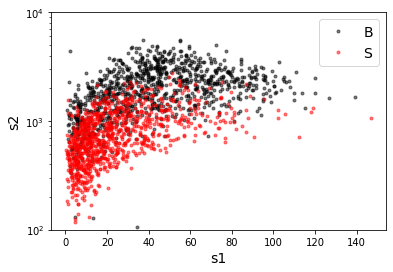

B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


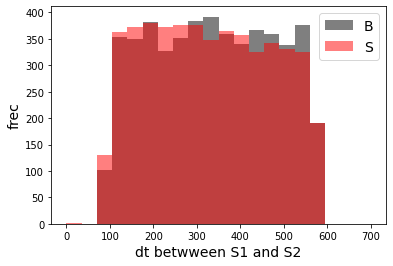

In [42]:

# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [43]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [44]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2724)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2724)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2724)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63814	validation_1-logloss:0.64607
[1]	validation_0-logloss:0.59258	validation_1-logloss:0.60930
[2]	validation_0-logloss:0.55359	validation_1-logloss:0.57506
[3]	validation_0-logloss:0.51893	validation_1-logloss:0.54725
[4]	validation_0-logloss:0.48953	validation_1-logloss:0.52440
[5]	validation_0-logloss:0.46304	validation_1-logloss:0.50326
[6]	validation_0-logloss:0.43974	validation_1-logloss:0.48432
[7]	validation_0-logloss:0.41906	validation_1-logloss:0.46851
[8]	validation_0-logloss:0.39966	validation_1-logloss:0.45537
[9]	validation_0-logloss:0.38257	validation_1-logloss:0.44281
[10]	validation_0-logloss:0.36611	validation_1-logloss:0.43072
[11]	validation_0-logloss:0.35048	validation_1-logloss:0.41989
[12]	validation_0-logloss:0.33686	validation_1-logloss:0.41011
[13]	validation_0-logloss:0.32338	validation_1-logloss:0.40116
[14]	validation_0-logloss:0.31160	validation_1-logloss:0.39385
[15]	validation_0-logloss:0.29898	validation_1-logloss:0.38613
[1

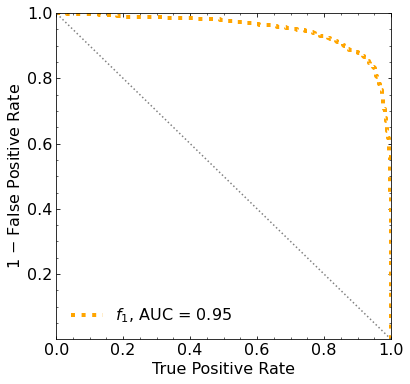

Classification score:


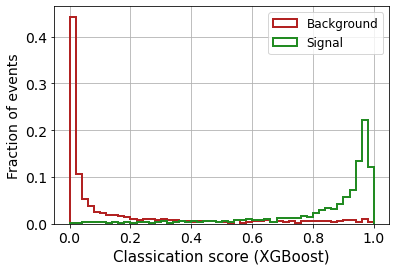


 ROC-AUC =  0.9517320888151738


In [45]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [46]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9517320888151738


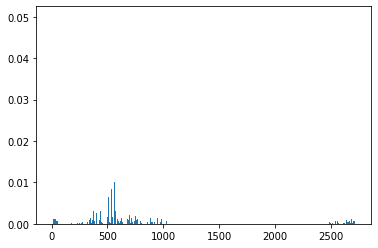

In [47]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

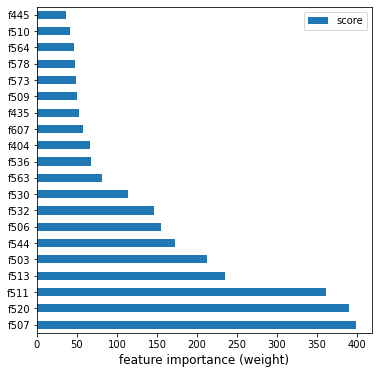

In [48]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                87200     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2568 - accuracy: 0.8925 - val_loss: 0.3498 - val_accuracy: 0.8746
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2622 - accuracy: 0.8982 - val_loss: 0.3500 - val_accuracy: 0.8704
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2996 - accuracy: 0.8671 - val_loss: 0.3363 - val_accuracy: 0.8662
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3146 - accuracy: 0.8615 - val_loss: 0.3466 - val_accuracy: 0.8566
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2670 - accuracy: 0.8968 - val_loss: 0.3557 - val_accuracy: 0.8686
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2655 - accuracy: 0.8930 - val_loss: 0.3250 - val_accuracy: 0.8710
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2701 - accuracy: 0.8834 - val_loss: 0.3492 - val_accuracy: 0.8590
Epoch 

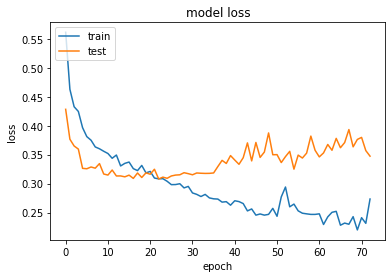

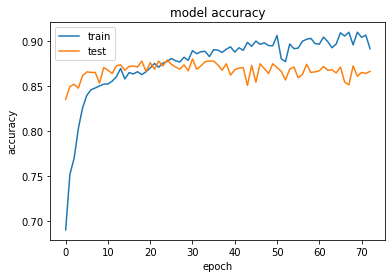

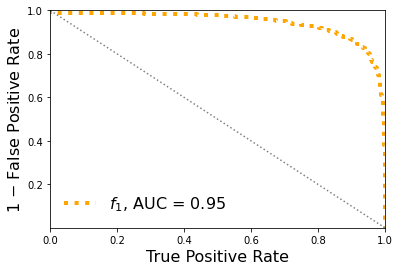

Classification score:


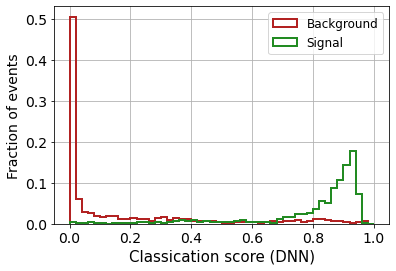


 ROC-AUC =  0.945866555518122


In [49]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [50]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.945866555518122


### CNN

In [51]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 4s 76ms/step - loss: 0.6342 - accuracy: 0.7216 - val_loss: 0.4636 - val_accuracy: 0.8224
Epoch 2/500
40/40 [==============================] - 3s 73ms/step - loss: 0.4498 - accuracy: 0.8349 - val_loss: 0.3992 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 3s 73ms/step - loss: 0.4230 - accuracy: 0.8492 - val_loss: 0.3779 - val_accuracy: 0.8650
Epoch 4/500
40/40 [==============================] - 3s 74ms/step - loss: 0.3924 - accuracy: 0.8609 - val_loss: 0.3636 - val_accuracy: 0.8602
Epoch 5/500
40/40 [==============================] - 3s 72ms/step - loss: 0.3827 - accuracy: 0.8690 - val_loss: 0.3553 - val_accuracy: 0.8674
Epoch 6/500
40/40 [==============================] - 3s 74ms/step - loss: 0.3633 - accuracy: 0.8692 - val_loss: 0.3493 - val_accuracy: 0.8686
Epoch 7/500
40/40 [==============================] - 3s 73ms/step - loss: 0.3670 - accuracy: 0.8598 - val_loss: 0.3459 - val_accuracy: 0.8680
Epoch 

40/40 [==============================] - 3s 75ms/step - loss: 0.2579 - accuracy: 0.9053 - val_loss: 0.3274 - val_accuracy: 0.8788
Epoch 59/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2386 - accuracy: 0.9137 - val_loss: 0.3242 - val_accuracy: 0.8788
Epoch 60/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2339 - accuracy: 0.9211 - val_loss: 0.3283 - val_accuracy: 0.8752
Epoch 61/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2357 - accuracy: 0.9183 - val_loss: 0.3514 - val_accuracy: 0.8728
Epoch 62/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2317 - accuracy: 0.9125 - val_loss: 0.3880 - val_accuracy: 0.8692
Epoch 63/500
40/40 [==============================] - 3s 76ms/step - loss: 0.2514 - accuracy: 0.9064 - val_loss: 0.3343 - val_accuracy: 0.8758
Epoch 64/500
40/40 [==============================] - 3s 75ms/step - loss: 0.2167 - accuracy: 0.9241 - val_loss: 0.3417 - val_accuracy: 0.8746
Epoch 65/500

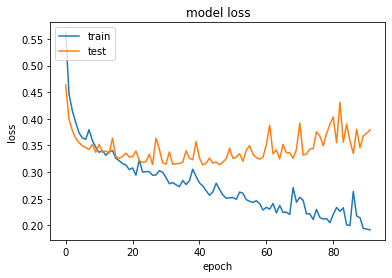

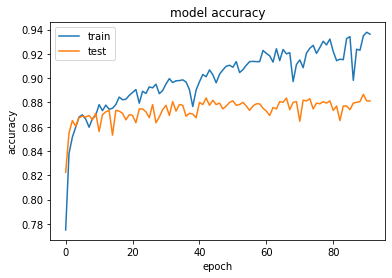

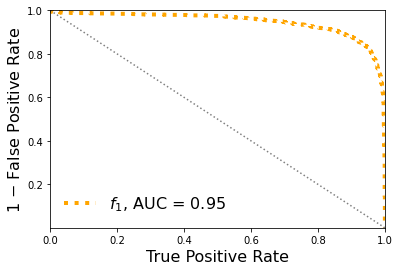

Classification score:


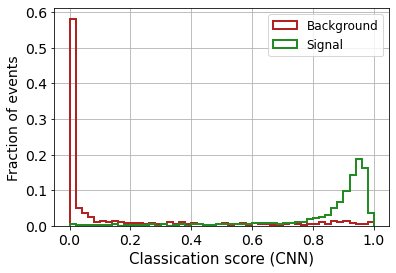


 ROC-AUC =  0.9465443168827729


In [52]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 2. only time diff

In [53]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (4999, 1)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 1)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 1)
y_mon5_test :  (3334,)



In [54]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2725)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2725)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2725)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63809	validation_1-logloss:0.64663
[1]	validation_0-logloss:0.59247	validation_1-logloss:0.60965
[2]	validation_0-logloss:0.55237	validation_1-logloss:0.57798
[3]	validation_0-logloss:0.51826	validation_1-logloss:0.54908
[4]	validation_0-logloss:0.48803	validation_1-logloss:0.52563
[5]	validation_0-logloss:0.46075	validation_1-logloss:0.50437
[6]	validation_0-logloss:0.43682	validation_1-logloss:0.48487
[7]	validation_0-logloss:0.41511	validation_1-logloss:0.46900
[8]	validation_0-logloss:0.39664	validation_1-logloss:0.45501
[9]	validation_0-logloss:0.37844	validation_1-logloss:0.44095
[10]	validation_0-logloss:0.36214	validation_1-logloss:0.42982
[11]	validation_0-logloss:0.34693	validation_1-logloss:0.41955
[12]	validation_0-logloss:0.33306	validation_1-logloss:0.41048
[13]	validation_0-logloss:0.31963	validation_1-logloss:0.40036
[14]	validation_0-logloss:0.30615	validation_1-logloss:0.39021
[15]	validation_0-logloss:0.29347	validation_1-logloss:0.38246
[1

[130]	validation_0-logloss:0.02537	validation_1-logloss:0.24472
[131]	validation_0-logloss:0.02504	validation_1-logloss:0.24442
[132]	validation_0-logloss:0.02477	validation_1-logloss:0.24467
[133]	validation_0-logloss:0.02446	validation_1-logloss:0.24437
[134]	validation_0-logloss:0.02416	validation_1-logloss:0.24464
[135]	validation_0-logloss:0.02377	validation_1-logloss:0.24475
[136]	validation_0-logloss:0.02344	validation_1-logloss:0.24413
[137]	validation_0-logloss:0.02319	validation_1-logloss:0.24430
[138]	validation_0-logloss:0.02285	validation_1-logloss:0.24413
[139]	validation_0-logloss:0.02268	validation_1-logloss:0.24445
[140]	validation_0-logloss:0.02231	validation_1-logloss:0.24460
[141]	validation_0-logloss:0.02193	validation_1-logloss:0.24540
[142]	validation_0-logloss:0.02151	validation_1-logloss:0.24574
[143]	validation_0-logloss:0.02113	validation_1-logloss:0.24540
[144]	validation_0-logloss:0.02072	validation_1-logloss:0.24538
[145]	validation_0-logloss:0.02041	valid

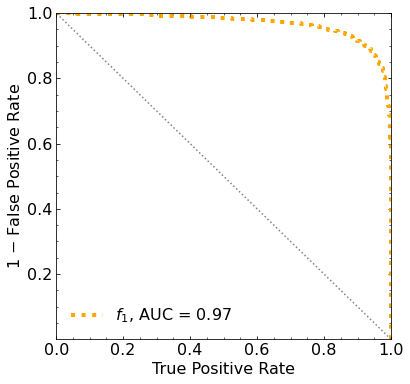

Classification score:


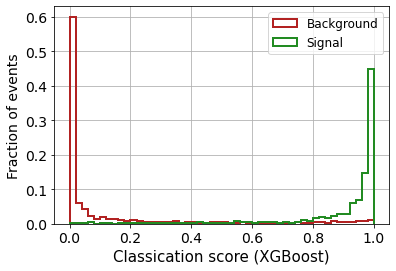


 ROC-AUC =  0.9680206776605823


In [55]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [56]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9680206776605823


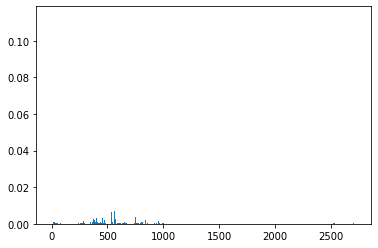

In [57]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

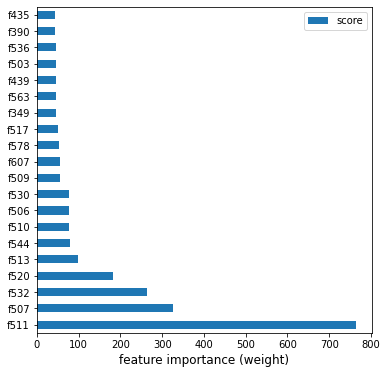


f2725: pdiffT


In [58]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()



print('\nf'+ str(len(classifier.feature_importances_)) + ': pdiffT')

### DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                87232     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_6 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2427 - accuracy: 0.9078 - val_loss: 0.2210 - val_accuracy: 0.9220
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2734 - accuracy: 0.8931 - val_loss: 0.2345 - val_accuracy: 0.9130
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2784 - accuracy: 0.8927 - val_loss: 0.2461 - val_accuracy: 0.9100
Epoch 53/500
40/40 [==============================] - 0s 2ms/step - loss: 0.2709 - accuracy: 0.8916 - val_loss: 0.2420 - val_accuracy: 0.9070
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2987 - accuracy: 0.8831 - val_loss: 0.2550 - val_accuracy: 0.9022
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2536 - accuracy: 0.9025 - val_loss: 0.2290 - val_accuracy: 0.9166
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2290 - accuracy: 0.9173 - val_loss: 0.2359 - val_accuracy: 0.9118
Epoch 

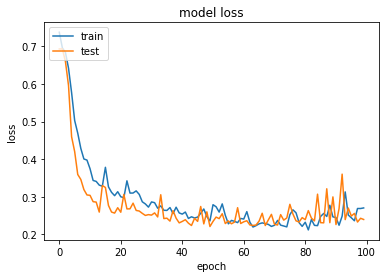

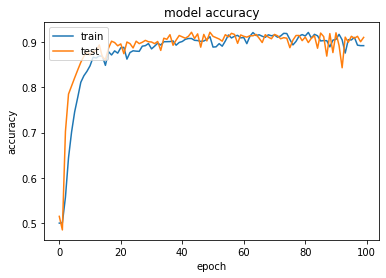

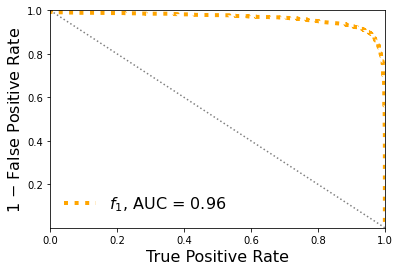

Classification score:


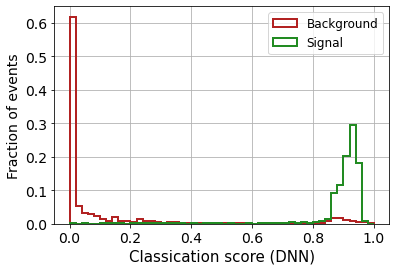


 ROC-AUC =  0.9645181307463941


In [59]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [60]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9645181307463941


### CNN

In [61]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 4s 80ms/step - loss: 0.7315 - accuracy: 0.6668 - val_loss: 0.4718 - val_accuracy: 0.8302
Epoch 2/500
40/40 [==============================] - 3s 75ms/step - loss: 0.4751 - accuracy: 0.8332 - val_loss: 0.3792 - val_accuracy: 0.8812
Epoch 3/500
40/40 [==============================] - 3s 76ms/step - loss: 0.4157 - accuracy: 0.8458 - val_loss: 0.3322 - val_accuracy: 0.8992
Epoch 4/500
40/40 [==============================] - 3s 75ms/step - loss: 0.3677 - accuracy: 0.8754 - val_loss: 0.3461 - val_accuracy: 0.8872
Epoch 5/500
40/40 [==============================] - 3s 75ms/step - loss: 0.3551 - accuracy: 0.8824 - val_loss: 0.3140 - val_accuracy: 0.9076
Epoch 6/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3465 - accuracy: 0.8847 - val_loss: 0.3270 - val_accuracy: 0.8842
Epoch 7/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3632 - accuracy: 0.8836 - val_loss: 0.2988 - val_accuracy: 0.9022
Epoch 

40/40 [==============================] - 3s 74ms/step - loss: 0.2141 - accuracy: 0.9304 - val_loss: 0.2640 - val_accuracy: 0.9166
Epoch 59/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2221 - accuracy: 0.9311 - val_loss: 0.2489 - val_accuracy: 0.9214
Epoch 60/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2195 - accuracy: 0.9295 - val_loss: 0.3168 - val_accuracy: 0.8914
Epoch 61/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2198 - accuracy: 0.9241 - val_loss: 0.2539 - val_accuracy: 0.9214
Epoch 62/500
40/40 [==============================] - 3s 73ms/step - loss: 0.2071 - accuracy: 0.9368 - val_loss: 0.2833 - val_accuracy: 0.9100
Epoch 63/500
40/40 [==============================] - 3s 73ms/step - loss: 0.1925 - accuracy: 0.9438 - val_loss: 0.2737 - val_accuracy: 0.9142
Epoch 64/500
40/40 [==============================] - 3s 74ms/step - loss: 0.2059 - accuracy: 0.9414 - val_loss: 0.2510 - val_accuracy: 0.9190
Epoch 65/500

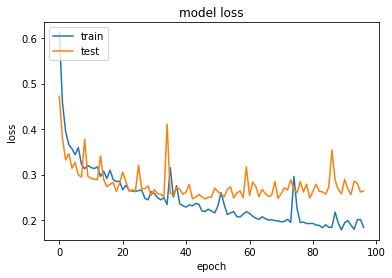

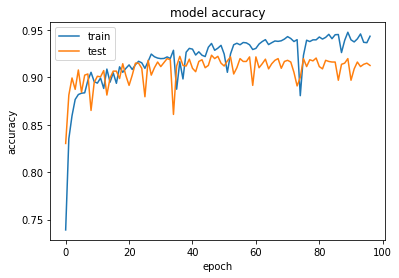

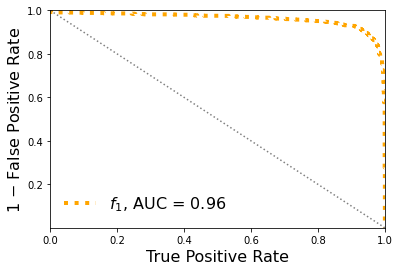

Classification score:


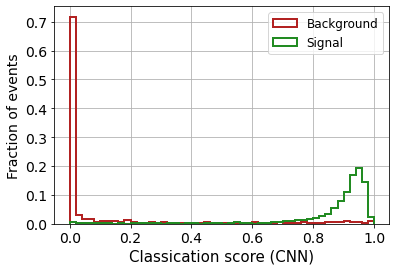


 ROC-AUC =  0.9617601135097313


In [62]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

## 3. All compressed features

In [63]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (4999, 17)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 17)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 17)
y_mon5_test :  (3334,)



##### Concatenate into one single big dataset

In [64]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val


In [65]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2741)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2741)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2741)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.62844	validation_1-logloss:0.63496
[1]	validation_0-logloss:0.57444	validation_1-logloss:0.58714
[2]	validation_0-logloss:0.52834	validation_1-logloss:0.54495
[3]	validation_0-logloss:0.49032	validation_1-logloss:0.51087
[4]	validation_0-logloss:0.45364	validation_1-logloss:0.47765
[5]	validation_0-logloss:0.42340	validation_1-logloss:0.45191
[6]	validation_0-logloss:0.39854	validation_1-logloss:0.43137
[7]	validation_0-logloss:0.37480	validation_1-logloss:0.41163
[8]	validation_0-logloss:0.35197	validation_1-logloss:0.39257
[9]	validation_0-logloss:0.33291	validation_1-logloss:0.37652
[10]	validation_0-logloss:0.31498	validation_1-logloss:0.36174
[11]	validation_0-logloss:0.29950	validation_1-logloss:0.35017
[12]	validation_0-logloss:0.28568	validation_1-logloss:0.33898
[13]	validation_0-logloss:0.27227	validation_1-logloss:0.32734
[14]	validation_0-logloss:0.26061	validation_1-logloss:0.31830
[15]	validation_0-logloss:0.24847	validation_1-logloss:0.30943
[1

[130]	validation_0-logloss:0.02604	validation_1-logloss:0.22146
[131]	validation_0-logloss:0.02560	validation_1-logloss:0.22209
[132]	validation_0-logloss:0.02512	validation_1-logloss:0.22192
[133]	validation_0-logloss:0.02479	validation_1-logloss:0.22212
[134]	validation_0-logloss:0.02431	validation_1-logloss:0.22223
[135]	validation_0-logloss:0.02391	validation_1-logloss:0.22218
[136]	validation_0-logloss:0.02378	validation_1-logloss:0.22220
[137]	validation_0-logloss:0.02365	validation_1-logloss:0.22223
[138]	validation_0-logloss:0.02319	validation_1-logloss:0.22226
[139]	validation_0-logloss:0.02294	validation_1-logloss:0.22263
[140]	validation_0-logloss:0.02260	validation_1-logloss:0.22284
[141]	validation_0-logloss:0.02233	validation_1-logloss:0.22307
[142]	validation_0-logloss:0.02210	validation_1-logloss:0.22322
[143]	validation_0-logloss:0.02195	validation_1-logloss:0.22309
[144]	validation_0-logloss:0.02169	validation_1-logloss:0.22344
[145]	validation_0-logloss:0.02139	valid

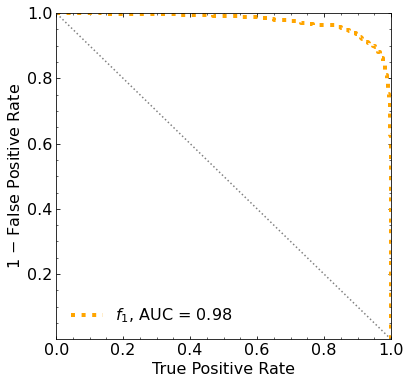

Classification score:


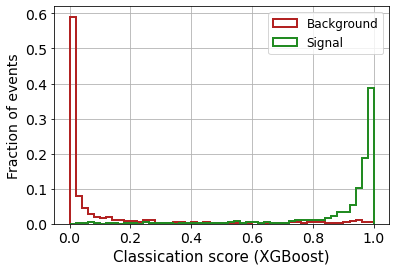


 ROC-AUC =  0.9751474301938189


In [86]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [87]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9751474301938189


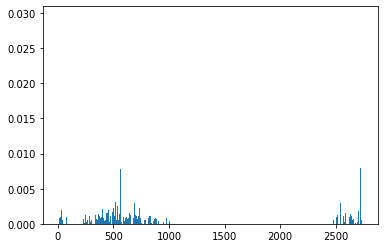

In [88]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

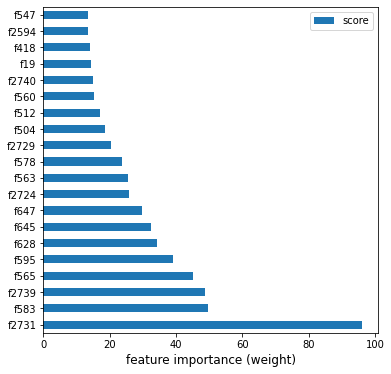


peakS1:   178 features  --> f0 to f177
peakS2:    2298 features  --> f178 to f2475
hits bot:   121 features  --> f2476 to f2596
hits top:   127 features  --> f2597 to f2723
resumed:     17 features  --> f2724 to f2740

 pA_S1 
 pH_S1 
 pHT_S1 
 pL_S1 
 pL90_S1 
 pRMSW_S1 
 pHTL_S1 
 pA_S2 
 pH_S2 
 pHT_S2 
 pL_S2 
 pL90_S2 
 pRMSW_S2 
 pHTL_S2 
 pbot 
 ptop 
 pdiffT


In [89]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

print('\npeakS1:   ' + str(max_pS1_both) + ' features  --> f0 to f' + str(max_pS1_both-1))
print('peakS2:    ' + str(max_pS2_both) + ' features  --> f' + str(max_pS1_both) + ' to f' + str(max_pS1_both+max_pS2_both-1))
print('hits bot:   121 features  --> f' + str(max_pS1_both+max_pS2_both) + ' to f' + str(max_pS1_both+max_pS2_both+120))
print('hits top:   127 features  --> f' + str(max_pS1_both+max_pS2_both+121) + ' to f' + str(max_pS1_both+max_pS2_both+121+126))
print('resumed:     17 features  --> f' + str(max_pS1_both+max_pS2_both+121+127) + ' to f' + str(max_pS1_both+max_pS2_both+121+127+16))

print('\n pA_S1',
      '\n pH_S1',
      '\n pHT_S1',
      '\n pL_S1',
      '\n pL90_S1',
      '\n pRMSW_S1',
      '\n pHTL_S1',
      '\n pA_S2',
      '\n pH_S2',
      '\n pHT_S2',
      '\n pL_S2',
      '\n pL90_S2',
      '\n pRMSW_S2',
      '\n pHTL_S2',
      '\n pbot', 
      '\n ptop',
      '\n pdiffT')

In [90]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  14
range of our data:  [[0, 1]]


In [91]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.1065


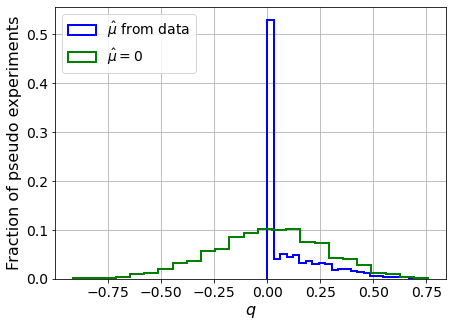

muhat mean:  0.38503656184205526
Z_bins:  0.11746414936103583
std Z_bins:  0.6475623082297536
Z_bins mu=0:  0.10630301852272395
std Z_bins mu=0:  1.2465453992455249

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.11


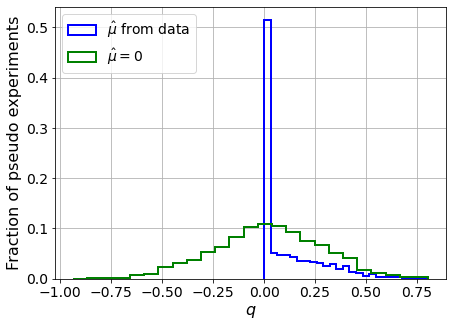

muhat mean:  0.15627162613218246
Z_bins:  0.14565361289959672
std Z_bins:  0.5440155623137132
Z_bins mu=0:  0.14422422619593495
std Z_bins mu=0:  0.922409850908715

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.097


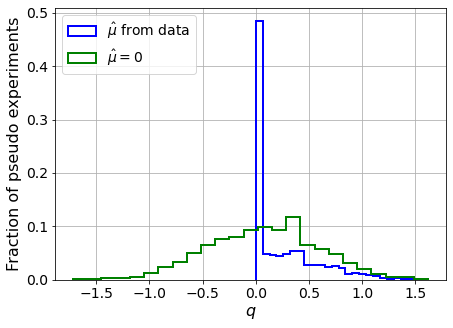

muhat mean:  0.16080288629577466
Z_bins:  0.2985496979968273
std Z_bins:  0.5375340802520916
Z_bins mu=0:  0.2971583467518789
std Z_bins mu=0:  0.8751840884211108

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.1105


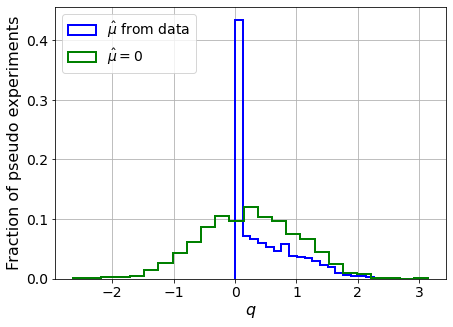

muhat mean:  0.0029851798943069346
Z_bins:  0.49454452117641917
std Z_bins:  0.5330643272257105
Z_bins mu=0:  0.49454452117641917
std Z_bins mu=0:  0.7934434455319489

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0955


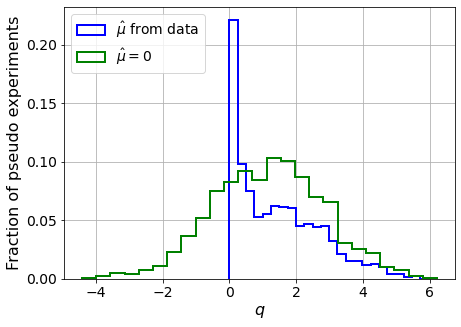

muhat mean:  0.003262340662683142
Z_bins:  1.1116847617623689
std Z_bins:  0.5758950515283571
Z_bins mu=0:  1.1116847617623689
std Z_bins mu=0:  0.7465549191984475

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.116


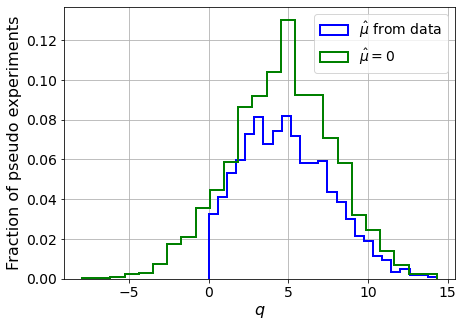

muhat mean:  0.015160407721024696
Z_bins:  2.175638506721198
std Z_bins:  0.6314238762972993
Z_bins mu=0:  2.175635118779296
std Z_bins mu=0:  0.7455482836223131

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.117


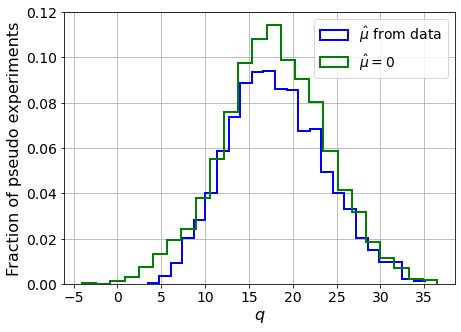

muhat mean:  0.0035759453508104194
Z_bins:  4.221218614352204
std Z_bins:  0.6517187648482358
Z_bins mu=0:  4.220550677943609
std Z_bins mu=0:  0.7074229438177905

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.1145


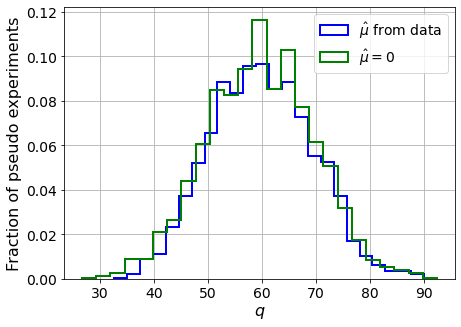

muhat mean:  0.00017216052952248568
Z_bins:  7.717891269043216
std Z_bins:  0.6109304898009544
Z_bins mu=0:  7.716836537801211
std Z_bins mu=0:  0.6401845675301798

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.105


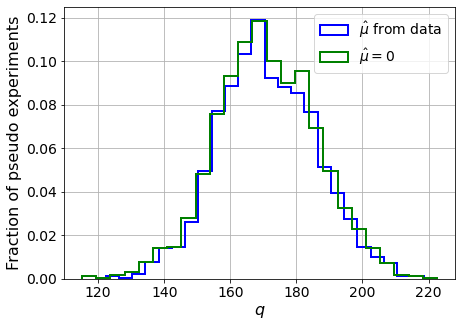

muhat mean:  0.000564263673730867
Z_bins:  13.047045640445877
std Z_bins:  0.5647633931680096
Z_bins mu=0:  13.046257202093264
std Z_bins mu=0:  0.58292346485996

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.091


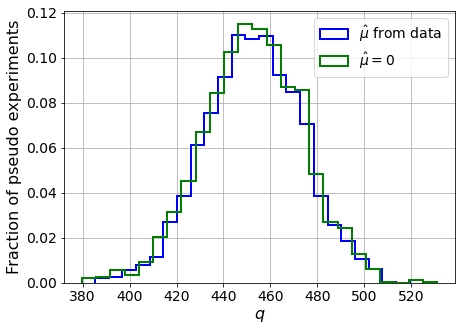

muhat mean:  -0.00040195789732391226
Z_bins:  21.280267496540187
std Z_bins:  0.48713111313986457
Z_bins mu=0:  21.27890860449882
std Z_bins mu=0:  0.4980389186293193

--------


 FINAL RESULT:

[[0.11746414936103583, 0.6475623082297536, 0.38503656184205526, 0.10630301852272395, 1.2465453992455249], [0.14565361289959672, 0.5440155623137132, 0.15627162613218246, 0.14422422619593495, 0.922409850908715], [0.2985496979968273, 0.5375340802520916, 0.16080288629577466, 0.2971583467518789, 0.8751840884211108], [0.49454452117641917, 0.5330643272257105, 0.0029851798943069346, 0.49454452117641917, 0.7934434455319489], [1.1116847617623689, 0.5758950515283571, 0.003262340662683142, 1.1116847617623689, 0.7465549191984475], [2.175638506721198, 0.6314238762972993, 0.015160407721024696, 2.175635118779296, 0.7455482836223131], [4.221218614352204, 0.6517187648482358, 0.0035759453508104194, 4.220550677943609, 0.7074229438177905], [7.717891269043216, 0.6109304898009544, 0.00017216052952248568, 7.7168365378

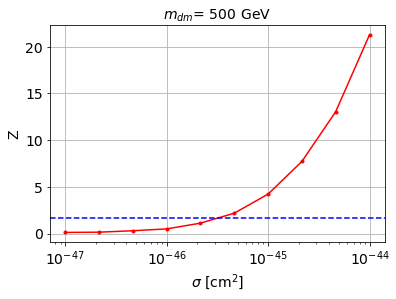


cross_BL_164:  3.153935602568244e-46
cross_BL_164_up:  2.038459406442983e-46
cross_BL_164_down:  4.813174256828044e-46


In [92]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                87744     
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_22 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3154 - accuracy: 0.8700 - val_loss: 0.2685 - val_accuracy: 0.8968
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3317 - accuracy: 0.8570 - val_loss: 0.2517 - val_accuracy: 0.8968
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3110 - accuracy: 0.8707 - val_loss: 0.2480 - val_accuracy: 0.9070
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3207 - accuracy: 0.8565 - val_loss: 0.2498 - val_accuracy: 0.9082
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3020 - accuracy: 0.8700 - val_loss: 0.2566 - val_accuracy: 0.9010
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2952 - accuracy: 0.8759 - val_loss: 0.2521 - val_accuracy: 0.9016
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3035 - accuracy: 0.8701 - val_loss: 0.3058 - val_accuracy: 0.8584
Epoch 

40/40 [==============================] - 0s 1ms/step - loss: 0.3826 - accuracy: 0.8171 - val_loss: 0.2522 - val_accuracy: 0.8980
Epoch 108/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3707 - accuracy: 0.8112 - val_loss: 0.2481 - val_accuracy: 0.8998
Epoch 109/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3372 - accuracy: 0.8233 - val_loss: 0.2340 - val_accuracy: 0.9100
Epoch 110/500
40/40 [==============================] - 0s 2ms/step - loss: 0.3296 - accuracy: 0.8364 - val_loss: 0.2527 - val_accuracy: 0.9022
Epoch 111/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3315 - accuracy: 0.8405 - val_loss: 0.2270 - val_accuracy: 0.9064
Epoch 112/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3530 - accuracy: 0.8306 - val_loss: 0.2443 - val_accuracy: 0.8992
Epoch 113/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3410 - accuracy: 0.8331 - val_loss: 0.2502 - val_accuracy: 0.8950
Epoch 114/500

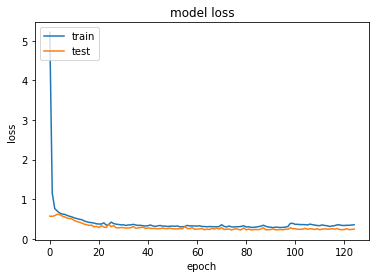

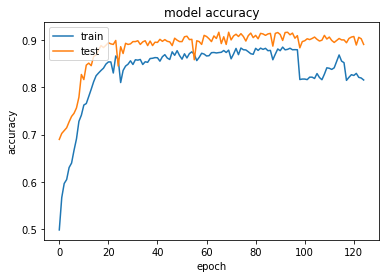

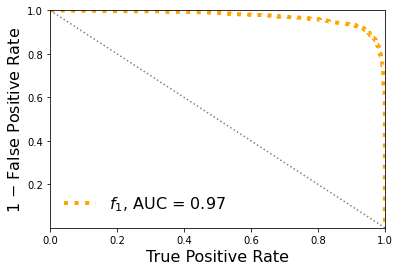

Classification score:


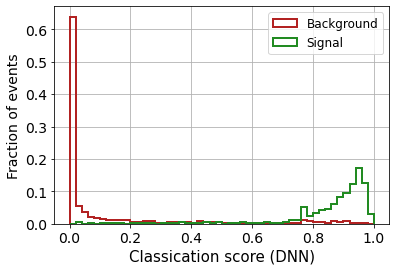


 ROC-AUC =  0.9722675742837974


In [82]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [83]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9722675742837974


### CNN

In [72]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 2s 42ms/step - loss: 1.1515 - accuracy: 0.6358 - val_loss: 0.4924 - val_accuracy: 0.8074
Epoch 2/500
40/40 [==============================] - 1s 37ms/step - loss: 0.5079 - accuracy: 0.7873 - val_loss: 0.4464 - val_accuracy: 0.8182
Epoch 3/500
40/40 [==============================] - 2s 38ms/step - loss: 0.4700 - accuracy: 0.8129 - val_loss: 0.4426 - val_accuracy: 0.8278
Epoch 4/500
40/40 [==============================] - 2s 38ms/step - loss: 0.4630 - accuracy: 0.8146 - val_loss: 0.4358 - val_accuracy: 0.8008
Epoch 5/500
40/40 [==============================] - 2s 38ms/step - loss: 0.4674 - accuracy: 0.8073 - val_loss: 0.4025 - val_accuracy: 0.8470
Epoch 6/500
40/40 [==============================] - 1s 37ms/step - loss: 0.4182 - accuracy: 0.8308 - val_loss: 0.3648 - val_accuracy: 0.8518
Epoch 7/500
40/40 [==============================] - 1s 37ms/step - loss: 0.3964 - accuracy: 0.8367 - val_loss: 0.3499 - val_accuracy: 0.8656
Epoch 

40/40 [==============================] - 1s 37ms/step - loss: 0.3226 - accuracy: 0.8390 - val_loss: 0.2487 - val_accuracy: 0.9178
Epoch 59/500
40/40 [==============================] - 1s 37ms/step - loss: 0.3197 - accuracy: 0.8413 - val_loss: 0.2329 - val_accuracy: 0.9178
Epoch 60/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3237 - accuracy: 0.8383 - val_loss: 0.2603 - val_accuracy: 0.9118
Epoch 61/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3425 - accuracy: 0.8419 - val_loss: 0.2329 - val_accuracy: 0.9202
Epoch 62/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3128 - accuracy: 0.8373 - val_loss: 0.2446 - val_accuracy: 0.9136
Epoch 63/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3322 - accuracy: 0.8375 - val_loss: 0.2492 - val_accuracy: 0.9196
Epoch 64/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3358 - accuracy: 0.8384 - val_loss: 0.2337 - val_accuracy: 0.9196
Epoch 65/500

40/40 [==============================] - 2s 38ms/step - loss: 0.3022 - accuracy: 0.8461 - val_loss: 0.2308 - val_accuracy: 0.9220
Epoch 116/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3121 - accuracy: 0.8375 - val_loss: 0.2237 - val_accuracy: 0.9226
Epoch 117/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3125 - accuracy: 0.8427 - val_loss: 0.2125 - val_accuracy: 0.9244
Epoch 118/500
40/40 [==============================] - 1s 37ms/step - loss: 0.2917 - accuracy: 0.8513 - val_loss: 0.2119 - val_accuracy: 0.9262
Epoch 119/500
40/40 [==============================] - 1s 37ms/step - loss: 0.2983 - accuracy: 0.8559 - val_loss: 0.2479 - val_accuracy: 0.9106
Epoch 120/500
40/40 [==============================] - 2s 39ms/step - loss: 0.2858 - accuracy: 0.8573 - val_loss: 0.2146 - val_accuracy: 0.9262
Epoch 121/500
40/40 [==============================] - 2s 38ms/step - loss: 0.2799 - accuracy: 0.8538 - val_loss: 0.2571 - val_accuracy: 0.8980
Epoch 

Epoch 172/500
40/40 [==============================] - 2s 39ms/step - loss: 0.2714 - accuracy: 0.8540 - val_loss: 0.2159 - val_accuracy: 0.9214
Epoch 173/500
40/40 [==============================] - 2s 38ms/step - loss: 0.2793 - accuracy: 0.8497 - val_loss: 0.2166 - val_accuracy: 0.9226
Epoch 174/500
40/40 [==============================] - 2s 39ms/step - loss: 0.2713 - accuracy: 0.8609 - val_loss: 0.2178 - val_accuracy: 0.9202
Epoch 175/500
40/40 [==============================] - 2s 38ms/step - loss: 0.2726 - accuracy: 0.8631 - val_loss: 0.2511 - val_accuracy: 0.9076
Epoch 176/500
40/40 [==============================] - 2s 40ms/step - loss: 0.2845 - accuracy: 0.8532 - val_loss: 0.2165 - val_accuracy: 0.9208
Epoch 177/500
40/40 [==============================] - 2s 39ms/step - loss: 0.2839 - accuracy: 0.8459 - val_loss: 0.2656 - val_accuracy: 0.9100
Epoch 178/500
40/40 [==============================] - 2s 39ms/step - loss: 0.2941 - accuracy: 0.8476 - val_loss: 0.2112 - val_accuracy:

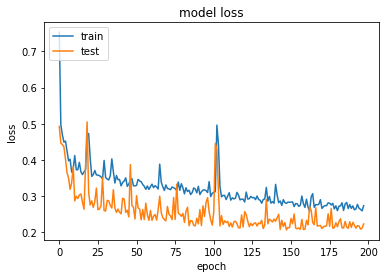

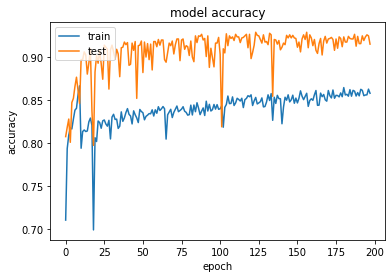

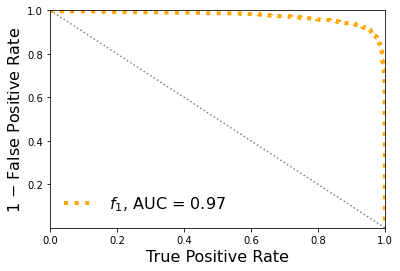

Classification score:


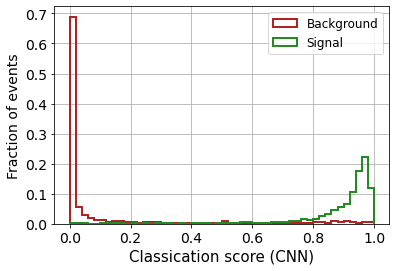


 ROC-AUC =  0.9728630900447186


In [81]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)